In [1]:
%config Completer.use_jedi = False

import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Classification

### Model Setup

In [43]:
df = pd.read_csv('./df_update.csv')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7122 entries, 0 to 7121
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cluster    7122 non-null   int64  
 1   SEQ        7122 non-null   int64  
 2   DAYS       7122 non-null   int64  
 3   HOURS      7122 non-null   int64  
 4   LABORFREE  7122 non-null   int64  
 5   WENDFREE   7122 non-null   int64  
 6   MOVE       7122 non-null   int64  
 7   TOTAL      7122 non-null   int64  
 8   HDB        7122 non-null   float64
 9   PRIVATE    7122 non-null   float64
 10  COMM       7122 non-null   float64
 11  INDU       7122 non-null   float64
 12  CYCLPATH   7122 non-null   float64
 13  BUS_STOP   7122 non-null   int64  
 14  ROADINT    7122 non-null   int64  
 15  ROAD_LIN   7122 non-null   int64  
 16  ENTROPY    7122 non-null   float64
 17  MRTDIST    7122 non-null   float64
 18  DISTCEN    7122 non-null   float64
 19  RAIN       7122 non-null   float64
 20  TEMPO   

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [46]:
columns_X = [
    'HOURS', 'HDB', 'PRIVATE', 'COMM', 'INDU', 'CYCLPATH', 'BUS_STOP',
    'ROADINT', 'ROAD_LIN', 'ENTROPY', 'MRTDIST', 'DISTCEN', 'LABORFREE',
    'WENDFREE'
]

columns_y = ['level']

X = df[columns_X].values
y = df[columns_y].values
print(X.shape, y.shape)

#encoding
enc = OrdinalEncoder()
y = enc.fit_transform(y)
target_names = ['high', 'low', 'normal']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    stratify=y)

(7122, 14) (7122, 1)


---------- Logistic ----------
              precision    recall  f1-score   support

        high       0.91      0.87      0.89       583
         low       1.00      1.00      1.00       517
      normal       0.93      0.95      0.94      1037

    accuracy                           0.94      2137
   macro avg       0.95      0.94      0.94      2137
weighted avg       0.94      0.94      0.94      2137

---------- RBF SVM ----------
              precision    recall  f1-score   support

        high       0.00      0.00      0.00       583
         low       0.00      0.00      0.00       517
      normal       0.49      1.00      0.65      1037

    accuracy                           0.49      2137
   macro avg       0.16      0.33      0.22      2137
weighted avg       0.24      0.49      0.32      2137

---------- Decision Tree ----------
              precision    recall  f1-score   support

        high       0.98      0.97      0.98       583
         low       1.00      1.0

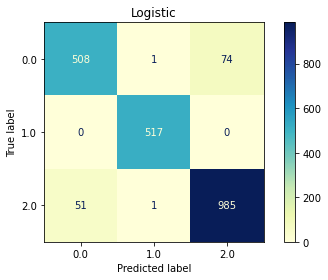

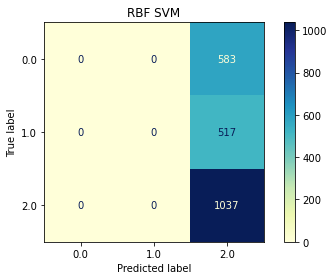

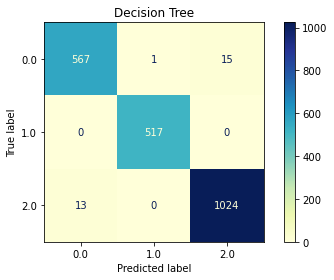

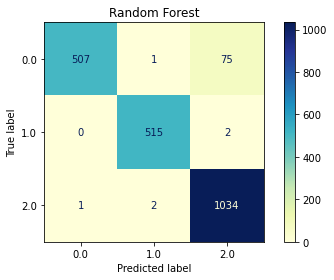

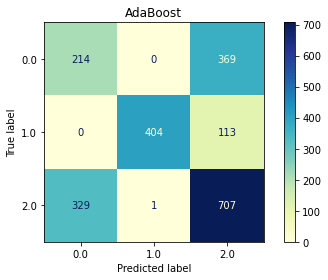

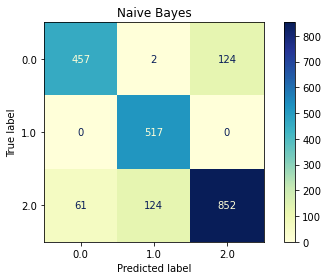

In [47]:
names = [
    "Logistic", "RBF SVM", "Decision Tree", "Random Forest",
    "AdaBoost", "Naive Bayes"
]

classifiers = [
    LogisticRegression(multi_class="multinomial",
                       solver="newton-cg",
                       max_iter=1000),
    SVC(kernel="rbf",gamma=2, C=0.1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=clf.classes_)
    disp.plot(cmap='YlGnBu')
    plt.title(name)
    plt.tight_layout()

    print("----------", name, "----------")
    print(classification_report(y_test, y_pred, target_names=target_names))
    #https://blog.csdn.net/akadiao/article/details/78788864
plt.show()

### Model Tuning

* According to results shown above, Decision and Random Forest will be selected to be tuned.

In [48]:
from sklearn.model_selection import GridSearchCV

最优分类器: {'criterion': 'entropy', 'max_depth': 30, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2}
--------------------------
最优分数: 0.8619841580521846
---------- Decision Tree ----------
              precision    recall  f1-score   support

        high       1.00      0.63      0.78       583
         low       1.00      0.89      0.94       517
      normal       0.79      1.00      0.88      1037

    accuracy                           0.87      2137
   macro avg       0.93      0.84      0.87      2137
weighted avg       0.90      0.87      0.87      2137



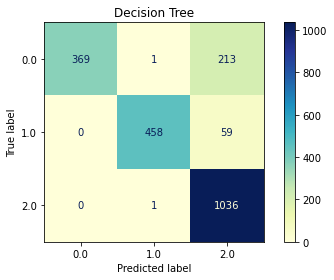

In [49]:
param = [{
    'criterion': ['gini'],
    'max_depth': [30, 50, 60, 100],
    'min_samples_leaf': [2, 3, 5, 10],
    'min_impurity_decrease': [0.1, 0.2, 0.5]
}, {
    'criterion': ['entropy'],
    'max_depth': [30, 60, 100],
    'min_samples_leaf': [2, 3, 5, 10],
    'min_impurity_decrease': [0.1, 0.2, 0.5]
}]

grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv=6)
grid.fit(X_train, y_train)
print('最优分类器:', grid.best_params_)
print('--------------------------')
print('最优分数:', grid.best_score_)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='YlGnBu')
plt.title("Decision Tree")
plt.tight_layout()

print("----------", "Decision Tree", "----------")
print(classification_report(y_test, y_pred, target_names=target_names))

最优分类器: {'criterion': 'gini', 'max_depth': 25, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 11}
--------------------------
最优分数: 0.9981947042079268
---------- Random Forest ----------
              precision    recall  f1-score   support

        high       1.00      0.99      1.00       583
         low       1.00      1.00      1.00       517
      normal       0.99      1.00      1.00      1037

    accuracy                           1.00      2137
   macro avg       1.00      1.00      1.00      2137
weighted avg       1.00      1.00      1.00      2137



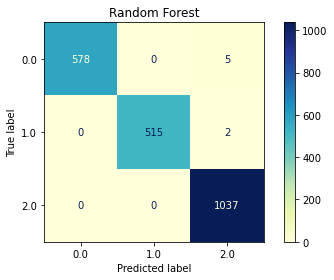

In [52]:
sqrtfeat = np.sqrt(X_train.shape[1])

param = {
    "n_estimators": range(1,101,10),
    "criterion": ["gini", "entropy"],
    "max_features": [3, 4, 5],
    "max_depth": [5, 10, 25],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid=param, cv=6)
grid.fit(X_train, y_train)
print('最优分类器:', grid.best_params_)
print('--------------------------')
print('最优分数:', grid.best_score_)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='YlGnBu')
plt.title("Random Forest")
plt.tight_layout()

print("----------", "Random Forest", "----------")
print(classification_report(y_test, y_pred, target_names=target_names))

### Feature Importance

In [53]:
clf.feature_importances_

array([2.99921560e-04, 1.28062470e-01, 3.52064901e-02, 3.90663806e-02,
       2.56525329e-02, 2.58281741e-02, 1.64852901e-01, 2.34136137e-01,
       1.24367361e-01, 2.56556225e-02, 3.93591057e-02, 1.57428285e-01,
       0.00000000e+00, 8.46181944e-05])

In [5]:
names = [
    'HOURS', 'HDB', 'PRIVATE', 'COMM', 'INDU', 'CYCLPATH', 'BUS_STOP',
    'ROADINT', 'ROAD_LIN', 'ENTROPY', 'MRTDIST', 'DISTCEN', 'LABORFREE',
    'WENDFREE'
]

values = [2.99921560e-04, 1.28062470e-01, 3.52064901e-02, 3.90663806e-02,
       2.56525329e-02, 2.58281741e-02, 1.64852901e-01, 2.34136137e-01,
       1.24367361e-01, 2.56556225e-02, 3.93591057e-02, 1.57428285e-01,
       0.00000000e+00, 8.46181944e-05]
coe_values = np.array(values).round(4)

In [6]:
df_names = pd.DataFrame(names,columns=['names'])
df_values = pd.DataFrame(coe_values,columns=['values'])
df_coe = pd.concat([df_names,df_values],axis=1)
df_coe.sort_values(by="values", ascending=False,inplace=True)
df_coe

,names,values
7,ROADINT,0.2341
6,BUS_STOP,0.1649
11,DISTCEN,0.1574
1,HDB,0.1281
8,ROAD_LIN,0.1244
10,MRTDIST,0.0394
3,COMM,0.0391
2,PRIVATE,0.0352
5,CYCLPATH,0.0258
4,INDU,0.0257


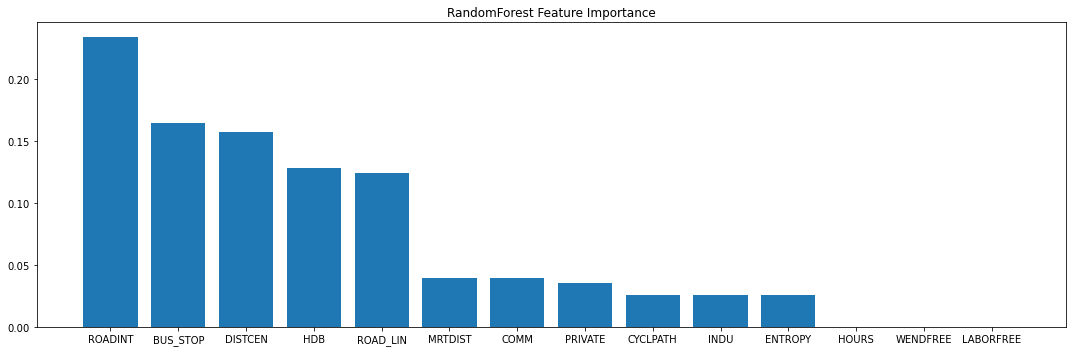

In [10]:
plt.figure(figsize=(15,5))
plt.bar(df_coe["names"], df_coe["values"])
plt.title("RandomForest Feature Importance")
plt.tight_layout()
plt.show()